# Interface gap-filling code to MBHB code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. To achieve that we separate the effect of glitches from the effect of gaps in the Spritz data, and we do so by creating ad-hoc datasets with only gaps.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [2]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v1.h5'
# open file with h5py
fid = h5py.File(fname)

In [3]:
# define function to print all attributes of hdf5 file recursively 
# from the LDC quicklook notebooks
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")
# print all dataset attributes (useful to see what's inside the HDF5 file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LISA_FREQUENCY_OFFSETS_32
        instru/config/LISA_GLITCH_FILE
        instru/config/LISA_GW_FILE_FS


### 1.2. Import the Spritz `tdi` datasets

The Spritz HDF5 file is structured in various groups:
- group `obs` containing `noise + signal + artifacts` (gaps + glitches)
- group `clean` containing `noise + signal`
- group `sky` containing `signal`
- group `noisefree` containing `signal + artifacts` (gaps + glitches)

Each of these groups hosts a dataset `tdi` that contains TDI combinations $X$, $Y$ and $Z$.

The import function `load_tdi_timeseries` also builds the missing TDI dataset:
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [4]:
# Print the tdi dataset object
print(fid['obs/tdi'])

<HDF5 dataset "tdi": shape (535680, 1), type "|V32">


In [5]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries

MLDC modules could not be loaded.


Let's load all datasets as numpy-recarray objects in a single dictionary `tdi`:

In [6]:
tdi = load_tdi_timeseries(fname = './data/LDC2_spritz_mbhb1_training_v1.h5')
tdi

{'obs': array([( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16),
        ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16),
        ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15),
        ...,
        (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21),
        (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21),
        (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)],
       dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]),
 'clean': array([( 8899200.,  1.48846530e-16,  6.75330625e-17, -3.88519776e-16),
        ( 8899205., -4.42617614e-16, -1.11055377e-16,  5.28572349e-16),
        ( 8899210., -7.98086900e-16,  7.99285186e-16, -1.47198925e-15),
        ...,
        (11577585., -9.25155200e-21, -7.01214434e-21,  7.23238271e-21),
        (11577590.,  5.74426785e-21, -1.04391992e-21, -4.90782302e-21),
        (11577595., -4.26376105e-21,  8.22171527e-21,  2.00825311e-20)],
       dtype=[('t', 

Let's take a look at the `'obs'` dataset:

In [7]:
tdi['obs']['X']

array([ 1.48846573e-16, -4.42617579e-16, -7.98086872e-16, ...,
       -9.29825703e-21,  5.70018992e-21, -4.30521190e-21])

In [8]:
# dataset is a numpy.recarray object with the length of the data time-series and fields ['t','X','Y','Z']
print(tdi['obs'])
print(tdi['obs'].dtype)

[( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16)
 ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16)
 ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15) ...
 (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21)
 (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21)
 (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)]
[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]


Set up dataset constant values:

In [9]:
# number of samples to skip at the beginning of the file
skip = 100 
# length of time-series
ndata = len(tdi['obs'][skip:])
# time step
dt = tdi['obs']['t'][1]-tdi['obs']['t'][0]
# sampling frequency
fs = 1.0/dt

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip, ndata, dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


## 2. Build orthogonal TDI combinations

We can proceed in two different ways to build orthogonal TDI combinations for all the datasets of our interest, i.e. `n+s`, `s`, `n`, `n+s+g` `n+g` data, according to our needs.

1. We can create separate numpy rec-arrays, one for each separate dataset
2. We can create a dictionary containing orthogonal TDI combinations for all imported datasets them


Each of these can then be wired into the Spritz analysis.

In [10]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi

In [11]:
# option 1 - separate numpy rec-arrays
td_datans = build_orthogonal_tdi(tdi['clean'])
td_datas  = build_orthogonal_tdi(tdi['sky'])
td_datan  = build_orthogonal_tdi(tdi['noise'])
td_datag  = build_orthogonal_tdi(tdi['clean_gapped'])
td_datang = build_orthogonal_tdi(tdi['noise_gapped'])
print(td_datans.dtype.names)

# # option 2 - single dictionary containing all numpy recarrays
# data = build_orthogonal_tdi(tdi)
# print(data.keys())
# print(data['obs'].dtype.names)

('t', 'A', 'E', 'T')


(11500000.0, 11570000.0)

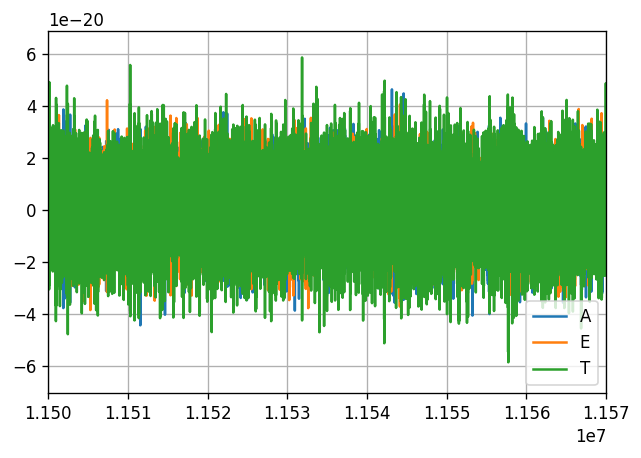

In [12]:
fig, ax = plt.subplots(1,1, dpi=120)
ax.plot(td_datan['t'], td_datan['A'], label='A')
ax.plot(td_datan['t'], td_datan['E'], label='E')
ax.plot(td_datan['t'], td_datan['T'], label='T')
ax.legend()
ax.grid()
ax.set_xlim([1.15e7,1.157e7])

## 3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

In [13]:
from bayesdawn.connect.fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

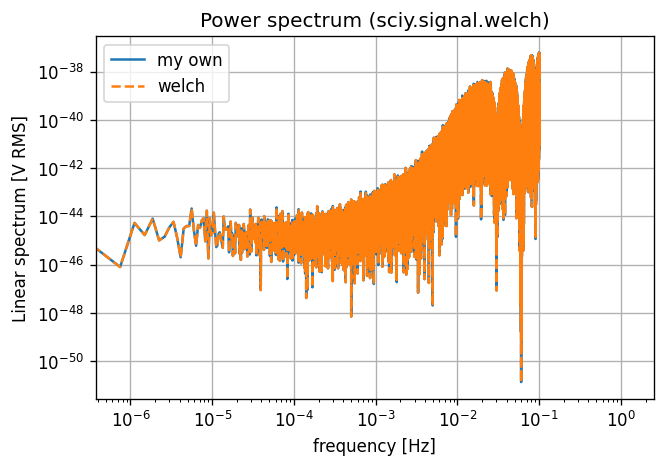

In [14]:
# Test psd and fft evaluation function
f, psdA, fft_A, _ = fft_olap_psd(td_datan, chan = 'A', plot = True)

In [15]:
# generate data in the right format for the MBHB search code
# split needs to be set to True

# noise data
datan, psddatan, scalefacn = generate_freq_data(td_datan, split=True, win='blackmanharris')
# noise + signal data
datans, psddatans, scalefacns = generate_freq_data(td_datans, split=True, win='blackmanharris')
# signal data
data, psddata, scalefac = generate_freq_data(td_datas, split=True, win='blackmanharris')

In [16]:
for param, val in zip(fid['sky/cat'].attrs.keys(),fid['sky/cat'][()]):
    print(param, ':', val)

CoalescenceTime : -0.30300442294174235
Distance : 1.2925183861048521
EclipticLatitude : 1.2031361791056812
EclipticLongitude : 2.097303543065685
Inclination : 0.747377
InitialAzimuthalAngleL : 0.8388
InitialPolarAngleL : 1323277.47932
Mass1 : 612485.5060299999
Mass2 : 11526944.921879262
PhaseAtCoalescence : 1.2201968860015653
PolarAngleOfSpin1 : 2.6919824500032945
PolarAngleOfSpin2 : 1.808398497592109
Polarization : 1.73941
Redshift : 13470.983558972537
Spin1 : 31558149.763545603
Spin2 : 3.0


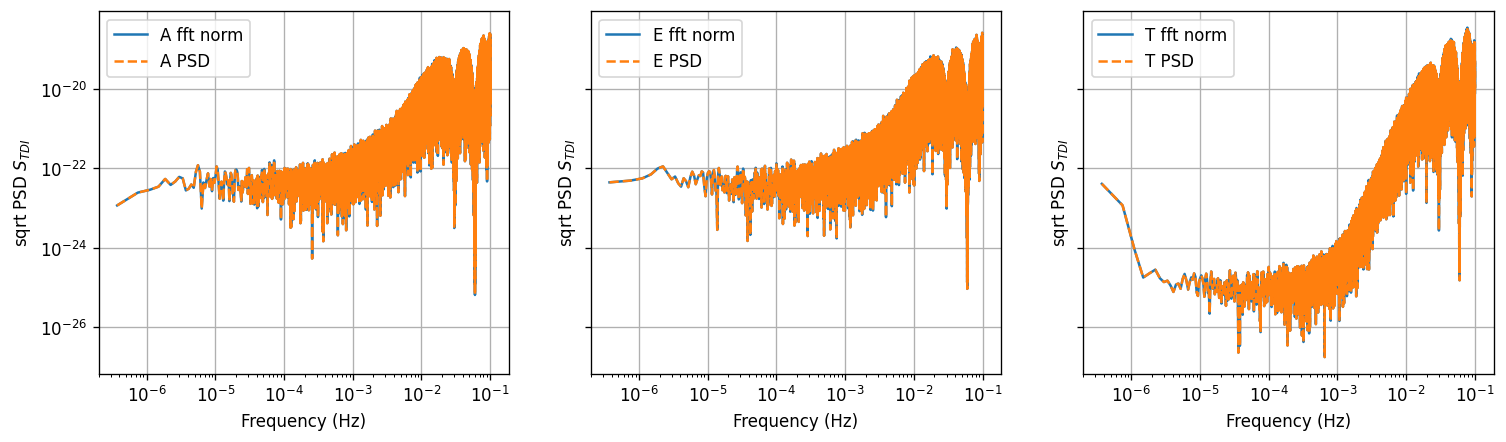

In [17]:
# plot data
fig, ax = plt.subplots(1,3,figsize=(15,4),dpi=120, sharey=True)
ax[0].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,1]+1j*datan[:,2]))), label='A fft norm')
ax[1].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,3]+1j*datan[:,4]))), label='E fft norm')
ax[2].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,5]+1j*datan[:,6]))), label='T fft norm')

ax[0].loglog(psddatan[:,0], np.sqrt(psddatan[:,1]), ls='--', label='A PSD')
ax[1].loglog(psddatan[:,0], np.sqrt(psddatan[:,2]), ls='--', label='E PSD')
ax[2].loglog(psddatan[:,0], np.sqrt(psddatan[:,3]), ls='--', label='T PSD')

for i in range(3):
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_ylabel(r'sqrt PSD $S_{TDI}$')
    ax[i].legend()
    ax[i].grid()                                                

## 2. Load the corresponding `ldc` noise model
It is also now possible to produce this kind of model from tabulated PSD data. 

- the Spritz `ldc` noise models can be easily ported to `lisabeta`

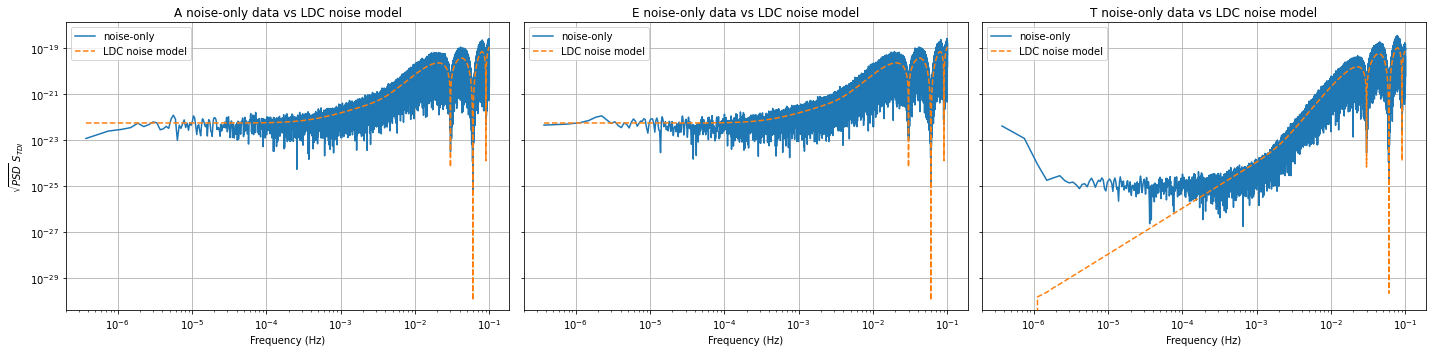

In [18]:
# Load noise models from ldc
# they can be translated easily into lisabeta
from ldc.lisa.noise import get_noise_model

# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, datan[:,0])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=datan[:,0])
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(datan[:,0], np.sqrt(psddatan[:,list(S.keys()).index(tdi)+1]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(datan[:,0], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

In [19]:
# print the SNR level for each TDI combination 

# usual SNR definition: numerical integration of the ratio between 
# the absolute value of the TDI data and its noise PSD, multiplied by 4
df = f[1]-f[0]

SNR2A=sum(np.abs(data[:,1]+1j*data[:,2])**2/S['A'])*4*df
print("A SNR:", np.sqrt(SNR2A), "\t SNR^2:", SNR2A)

SNR2E=sum(np.abs(data[:,3]+1j*data[:,4])**2/S['E'])*4*df
print("E SNR:", np.sqrt(SNR2E), "\t SNR^2:", SNR2E)

SNR2T=sum(np.abs(data[:,5]+1j*data[:,6])**2/S['T'])*4*df
print("T SNR:", np.sqrt(SNR2T), "\t SNR^2:", SNR2T)

print("Total SNR:", np.sqrt(SNR2A+SNR2E+SNR2T))

A SNR: 2.6507894964372083 	 SNR^2: 7.026684954421829
E SNR: 2.7508315304877025 	 SNR^2: 7.567074109125316
T SNR: inf 	 SNR^2: inf
Total SNR: inf


/tmp/ipykernel_3924346/2841131443.py:13: RuntimeWarning: divide by zero encountered in true_divide
  SNR2T=sum(np.abs(data[:,5]+1j*data[:,6])**2/S['T'])*4*df


## 3. Plot
For comparing spectra, and compare data with noise models.

Here we compare the three data realizations (noise, signal and noise + signal) and evaluate the gaussianity of the noise realization.

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

Note that `n + s` data deviate significantly from the Gaussian behavior for A and E, but not as much for T.

In [20]:
from bayesdawn.connect.fillgaps import plot_compare_spectra_timeseries
from bayesdawn.connect.lisabeta_fill_gaps import plot_compare_spectra

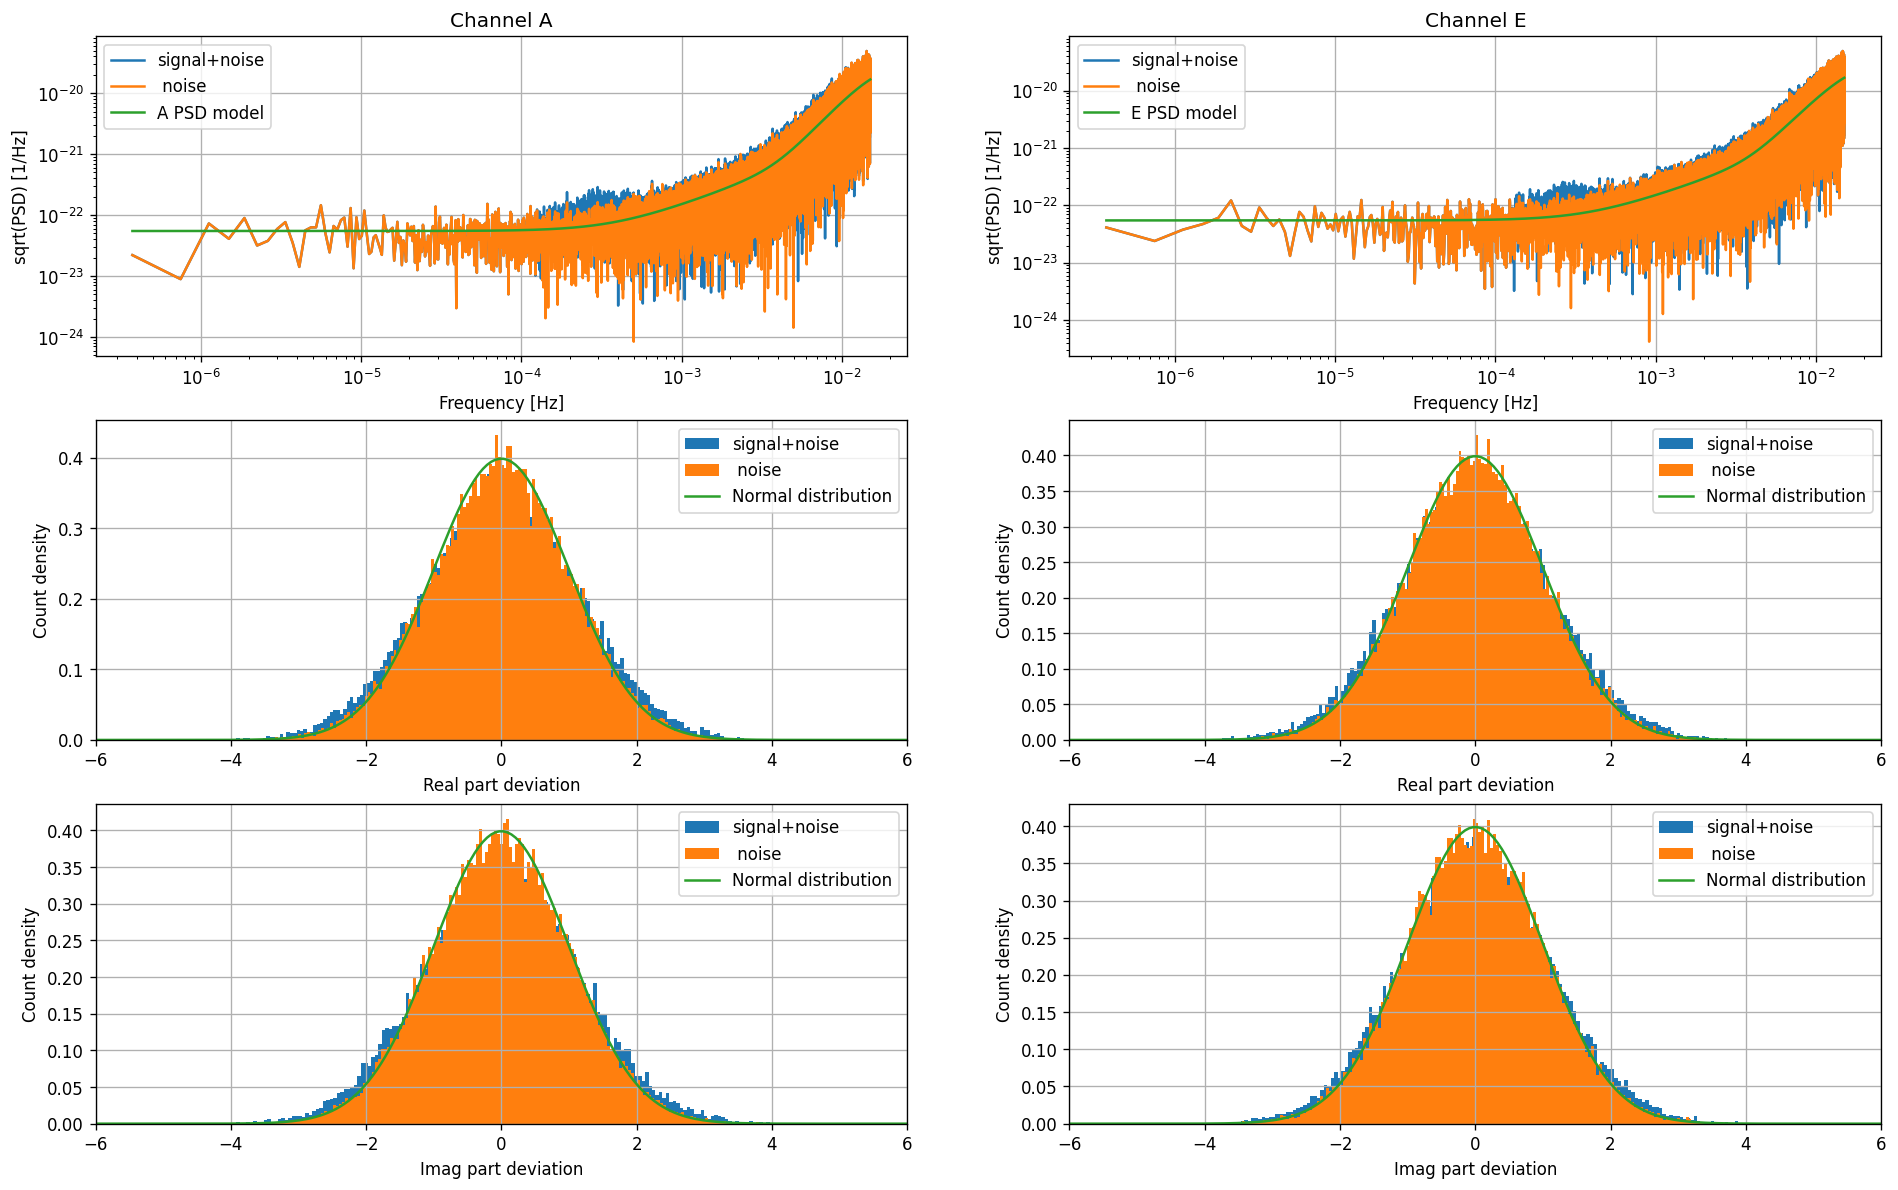

In [21]:
# plot_compare_spectra([datans, datan],
#                      LISAnoise,
#                      labels=["with signal","noise only"])

# plot comparison
plot_compare_spectra_timeseries(data = [td_datans, td_datan] ,
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['signal+noise', ' noise'], 
                                save = False)

## 4. Specify some gaps and generate gapped data
Based on the signal + noise data, we are going to add some gaps to this data realization.

In [22]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import construct_gap_mask

### 4.1 Data imputation with short custom gaps 


#### 4.1.1 Specify some short gaps (1000 samples) and generate gapped data
Based on the `n` data, we are going to add some gaps to this data realization.

We're going to start with 3 small gaps 20-sample 100-seconds long as in the original notebook to test the code.

In [23]:
# Set up gaps

# # number of frequencies
# nf=len(datans)+int(fs[0]/df-.5)

# print('nn', 'nf', 'nf-nn', sep = '\t')
# print(nn, nf, nf-nn, sep = '\t', end = '\n---------------------\n')
# print('f0', '\tdf', 'f0/df', sep = '\t')
# print(fs[0], df, fs[0]/df, sep = '\t')
# # create buffer of complex data for frequencies
# bufdata = 1j*np.zeros(nf)
# fftfs = df*np.arange(nf)
# nt = 2*(nf-1)
# dt = 1/(fs[-1]*2)

# # tscalefac=np.sqrt(.5)/nt/df
# # tscalefac*=tscalefac
# tscalefac=1/dt

# # Construct time-domain data starting from the frequency domain data we have in our dataset
# print('\nConstruct time-domain data')
# # note y is the inverse-fft which is time-domain channel*dt in our usage
# y = []
# nchan = 3
# for i in range(nchan):
#     bufdata[nf-nn:] = datans[:,1+i*2] + 1j*datans[:,2+i*2]
#     y += [np.fft.irfft(bufdata)*tscalefac]
#     print('y['+str(i)+'],shape=',y[i].shape)

In [24]:
# we already have time-domain data available, therefore we don't need to construct them starting from the noise spectrum
# we'll just use the LDC time-domain data to inject gaps
td_datans

rec.array([( 8899700., -1.41313368e-20,  8.71762827e-21,  6.29922025e-21),
           ( 8899705.,  1.10272357e-20,  7.69247950e-21,  1.77453779e-20),
           ( 8899710., -1.05706946e-20, -1.83141119e-20, -1.77660162e-20),
           ...,
           (11577585.,  1.16559020e-20,  4.90106947e-21, -5.21423136e-21),
           (11577590., -7.53216569e-21,  1.19383422e-21, -1.19785797e-22),
           (11577595.,  1.72154282e-20, -2.55016594e-22,  1.38797806e-20)],
          dtype=[('t', '<f8'), ('A', '<f8'), ('E', '<f8'), ('T', '<f8')])

In [25]:
SAVE = False
n_gaps = 3
gap_length = 1000

In [26]:
#construct gap mask
mask = np.ones(ndata)
ts = np.arange(ndata) * dt

maskinfo = construct_gap_mask(ndata,
                              n_gaps = n_gaps,
                              gap_length = gap_length,
                              verbose = True)
mask = maskinfo['mask']

Defined gaps:
  gap0 (246872:247872)
  gap1 (32707:33707)
  gap2 (258166:259166)


In [27]:
# y_masked=[]
# for i in range(nchan):
#     y_masked += [ mask * y[i] ]
# for i in range(n_gaps):
#     print('gap', i,':\n\tsamples:', gapstarts[i],'< i <', gapends[i], '\n\tseconds:', ts[gapstarts[i]],'< t <', ts[gapends[i]])

In [28]:
td_datans_masked = td_datans.copy()

for names in td_datans.dtype.names[1:]:
    td_datans_masked[names] = mask * td_datans[names]

for i in range(len(maskinfo['starts'])):
    print('gap', i,
          ':\n\tsamples:', maskinfo['starts'][i],
          '< i <', maskinfo['ends'][i],
          '\n\tseconds:', ts[maskinfo['starts'][i]],
          '< t <', ts[maskinfo['ends'][i]])

gap 0 :
	samples: 246872 < i < 247872 
	seconds: 1234360.0 < t < 1239360.0
gap 1 :
	samples: 32707 < i < 33707 
	seconds: 163535.0 < t < 168535.0
gap 2 :
	samples: 258166 < i < 259166 
	seconds: 1290830.0 < t < 1295830.0


### Define some functions for gap processing
- `reconstruct_time_domain`: 
  from FD data
- `construct_specialized_data`:
  TD to FD conversion
- Plot demonstrates effectiveness in preproducing the data by transforming to TD and back to FD with these functions

In [29]:
from bayesdawn.connect.lisabeta_fill_gaps import reconstruct_time_domain, construct_specialized_data

In [30]:
# # create a copy of noise only data
# datax = datan
# # transform data to time-domain (output is a list of ndarrays)
# yy = reconstruct_time_domain(datax, 3)
# # back to frequency domain
# yyf = construct_specialized_data(yy, 3, df, fs[0])
# # back to time domain again to check method consistency
# yyt = reconstruct_time_domain(yyf, 3)

# dyy = yyf.copy()
# dyy[:,1:] -= datax[:,1:]

In [31]:
# datax[:,0].shape
# datax[:,0][1]-datax[:,0][0]

In [32]:
# plot_compare_spectra([datax, yyf, dyy],
#                      LISAnoise,
#                      labels=['orig','transformed','diff'])

### Function for viewing/comparing gap data

Given a set of gaps, together with various (eg gapped and ungapped) versions of the TD data, produces comparison plots for each channel around each gap.

In [33]:
# from lisabeta_fill_gaps import view_gaps
from bayesdawn.connect.fillgaps import view_gaps

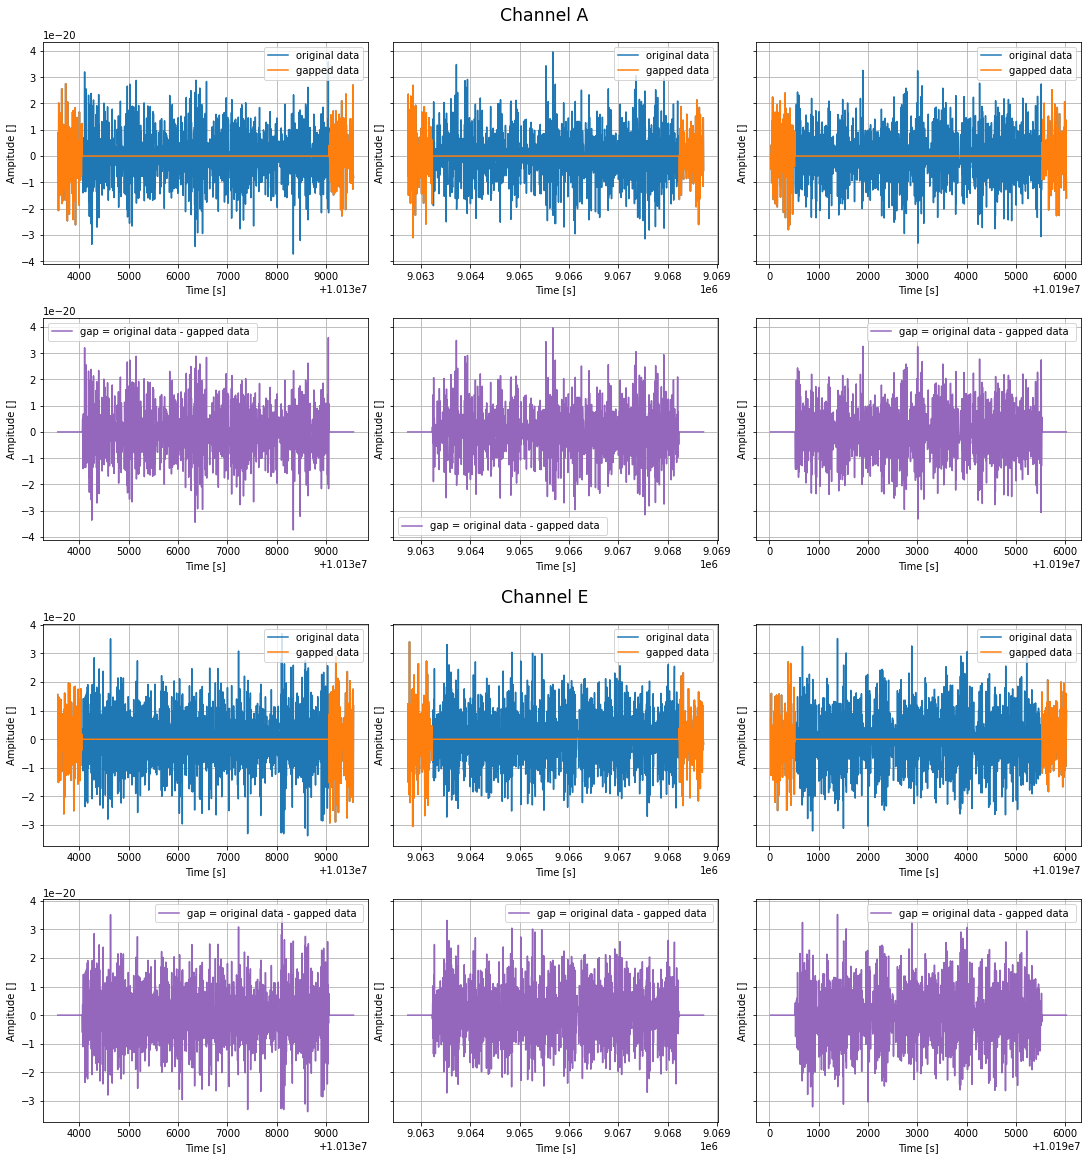

In [34]:
# view_gaps(ts,
#           [y, y_masked, yy, yyt],
#           gapstarts[:3], gapends[:3],
#           labels=['data', 'gapped', 'generated by func', 'transformed and reconstructed'])

view_gaps(ts = td_datans['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]]],
          yg = [td_datans_masked[names] for names in td_datans_masked.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'],
          labels=['original data'])

## 5. Define a `bayesdawn` PSD model class built on the `lisabeta` PSD model
Then show a test of its application

In [35]:
# from bayesdawn import datamodel, psdmodel

# # Embed the PSD function for a single channel in a class
# class chanPSD(psdmodel.PSD):

#     def __init__(self, n_data, df, chan, LISAnoise, TDIrescaled=False, f0=0, dered_f0=0, dered_pow=2):
#         psdmodel.PSD.__init__(self, n_data, df, fmin=None, fmax=None)
#         self.LISAnoise = LISAnoise
#         self.chan = chan+1
#         self.TDIrescaled = TDIrescaled
#         self.f0 = f0-df
#         self.df = df
#         self.i0 = int(f0/df+0.5)
#         self.dered_f0 = dered_f0
#         self.dered_pow = dered_pow
        
#     def psd_fn(self, x):
#         #print('Calling pyLISAnoise with:\n  LISAnoise=',self.LISAnoise,"\n  chan=",self.chan,"\n  TDIrescaled=",resc,"\n  x=",x)
#         xx = x
#         psd = pyLISAnoise.LISANoisePSDFunction(self.LISAnoise,self.chan,TDIrescaled=self.TDIrescaled).apply(xx)
#         print('x.shape, psd.shape:', x.shape, psd.shape)        
#         #psd[:self.i0]=psd[self.i0]
#         if self.dered_f0>0:
#             cut = self.dered_f0
#             # !!!! hack the low-f fall-off test
#             psd[xx<cut]*=(xx[xx<cut]/cut)**self.dered_pow
#         return psd

In [36]:
# # Instantiate the psd class list for each TDI channel
# psd_cls = []

# for i in range(3):
#     psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[10]))#, dered_f0=1e-5))   

# # Check the PSD on the reconstructed time-domain data
# # produce time domain noise time-series
# yyn = reconstruct_time_domain(datan, 3)
# yynfft = []
# ff = []

# print('fs.shape:', fs.shape)

# #for each time-series
# for td in yyn:
#     # evaluate dft
#     yynfft += [np.fft.rfft(td)] 
#     Nt = len(td)
#     # nyquist frequency
#     fs2nyq = Nt * df
#     tutscalefac = np.sqrt(2 / (Nt*fs2nyq))
#     print('Nt, fs, scalefac:', Nt, fs2nyq, tutscalefac)
#     # create frequency mesh
#     ff += [np.fft.rfftfreq(Nt) * fs2nyq]
#     print('shape:', td.shape,'->', yynfft[-1].shape,' ff.shape',ff[-1].shape)
    
# # From tutorial: scalefac = np.sqrt(2 / (n_data*fs)), but 'fs'= n_data * df
# tutorial_scalefac = np.sqrt(2 / df)/(len(yynfft[0])-1)/2
# print('tutorial_scalefac', tutorial_scalefac)

## 5. Define a bayesdawn PSD model class built on the ldc PSD model

In [37]:
from bayesdawn.connect.fillgaps import LDCModelPSD, LDCCorrectedModelPSD
from bayesdawn import datamodel, psdmodel
import time

## 6. Apply imputation to noise data and compare spectra

### Define some functions for concretely applying the bayesdawn gap impuation on  a set of FD data channels
- create_imputation: Make a (multi-channel) set of bayesdawn imputation models from given PSD data with a specified gap mask
- update_imputation: Perform the imputation on a set of FD residual data returning a revised version of the residual data, again in FD with re-drawn gap data.

In [38]:
from bayesdawn.connect.lisabeta_fill_gaps import create_imputation, update_imputation

In [39]:
# # get frequency 
# fs = datan[:,0]
# # get frequency spacing
# df = (fs[-1]-fs[0])/(len(datan)-1) 

# # dft of time-domain data generated from noise frequency-domain data
# datan_control = construct_specialized_data(reconstruct_time_domain(datan, nchan), nchan, df,fs[20])

# # generate the PSD noise class
# psd_cls = []
# for i in range(3):
#     #psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[10])) 
#     psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[20], dered_f0=3e-5, dered_pow=3))   
    

# # generate imputation class instances for all tdi channels and perform offline computation
# imp = create_imputation(mask,psd_cls,nchan,method='woodbury')
# print('created')

# # perform actual imputation
# # datan1 = update_imputation(mask,imp,nchan,datan,verbose=True,psd=psd_cls)
# datan1 = update_imputation(mask,imp,nchan,datan,verbose=True,psd=psd_cls,nfuzz=15000)
# print('updated')

# # plot comparison of spectra
# plot_compare_spectra([datan[20:], datan1[20:], datan_control],LISAnoise,labels=['before','after','control'])
                                            

In [ ]:
# run imputation on time-domain data
names = ['A', 'E', 'T']
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# set up flags and variables
mask = maskinfo['mask']
PSD_CORRECTION = False
td_data_rec = td_datans_masked.copy()
    
# instantiate the PSD noise class
if PSD_CORRECTION:
    for tdi in names:
        psd_cls.append(LDCCorrectedModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
else:
    for tdi in names:
        psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
    

In [ ]:
# Perform data imputation
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    y_masked = td_datans_masked[names[tdi]]
    s = np.zeros(len(mask))  #for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=50, nb=50)]
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
    t1 = time.time()
#     imp_cls[tdi].update_psd(psd_cls[tdi])
    # Re-compute of PSD-dependent terms
    imp_cls[tdi].compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_res = imp_cls[tdi].impute(y_masked, draw=True)
    # Update the data residuals
    t2 = time.time()
    print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
    td_data_rec[names[tdi]] = y_res

In [ ]:
view_gaps(ts = td_datans['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]], 
                [td_data_rec[names] for names in td_datans.dtype.names[1:]]],
          yg = [td_datans_masked[names] for names in td_datans.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = SAVE)

In [ ]:
# generate fft and psd from reconstructed data
fdatan_rec, psddata_rec, _ = generate_freq_data(td_data_rec, split = True) 

In [ ]:
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan_rec[:,0])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec[:,0])
# plot comparison
plot_compare_spectra_timeseries(data = [td_datans, td_data_rec],#,data_masked], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Downavg original signal+noise', 'Reconstructed signal+noise'],#, 'gapped data'], 
                                save = SAVE)